# TP4 Projeto de Bloco: Inteligência Artificial e Machine Learning [24E3_5]
# Alberto F. Pluecker - 25.11.2024
https://colab.research.google.com/drive/1p_aCPWQCr0OJ9nnaMOrvPV0oBqr1bN-d?usp=sharing

In [2]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("notshrirang/spotify-million-song-dataset")
csv = f"{path}/spotify_millsongdata.csv"

data = pd.read_csv(csv).dropna()
data.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


## 1. Criação das features: Computar o Term Frequency-Inverse Document Frequency (TF-IDF) para representar a importância das palavras em um conjunto de documentos.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords, words

nltk.download('words', quiet=True)
valid_words = set(words.words())

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text) # caracteres especiais
    text = re.sub(r'\b\d+\b', '', text) # numeros isolados
    text = text.lower()

    filtered_text = ' '.join(
        word for word in text.split()
        if word not in stop_words and word in valid_words and len(word) > 2
    )

    return filtered_text

data['cleaned_text'] = data['text'].apply(preprocess_text)

# Computar o TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=4000, # limite arbitrário x colunas, para agilizar a execução das tarefas
    min_df=5, # exclui palavras que ocorrem em menos de 5 entradas
    stop_words='english',
    token_pattern=r'\b[A-Za-z]+\b'

)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])

# Convertendo para DataFrame para análise
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

tfidf_df.head()

,abandon,abandoned,abide,able,aboard,absolutely,absurd,abuse,accept,accident,...,younger,youth,youve,yuh,yuletide,zero,zombie,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Modelagem de Tópicos com LDA: Aplicar o algoritmo LDA para identificar tópicos prevalentes nos dados. A seleção do número de tópicos será baseada em métricas de coerência para garantir a relevância e a distinção entre os tópicos identificados.

In [4]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# pré-processamento e tokenização do texto
data['tokenized_text'] = data['cleaned_text'].apply(lambda x: x.split())

# criar dicionário e corpus
dictionary = corpora.Dictionary(data['tokenized_text'])
dictionary.filter_extremes(no_below=3, no_above=0.9)
dictionary.filter_n_most_frequent(2000)

sample_data = data.sample(frac=0.5)  # Usar 50% dos dados para agilizar o processo
sample_corpus = [dictionary.doc2bow(text) for text in sample_data['tokenized_text']]

corpus = [dictionary.doc2bow(text) for text in data['tokenized_text']]

# treinar LDA e calcular coerência
def train_lda_and_evaluate(corpus, dictionary, texts, num_topics, sample_size=5000):
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        chunksize=20,
        alpha='auto',
    )
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts[:sample_size],
        dictionary=dictionary,
        coherence='u_mass'
    )
    return lda_model, coherence_model.get_coherence()

# avaliar diferentes números de tópicos
topic_range = range(4, 11)
results = []

for num_topics in topic_range:
    lda_model, coherence = train_lda_and_evaluate(corpus, dictionary, data['tokenized_text'], num_topics)
    results.append({'num_topics': num_topics, 'coherence': coherence})

# selecionar o número ideal de tópicos
results_df = pd.DataFrame(results).sort_values(by='coherence', ascending=False)
print("Resultados de Coerência:")
print(results_df)

best_num_topics = results_df.iloc[0]['num_topics']
best_lda_model, _ = train_lda_and_evaluate(corpus, dictionary, data['tokenized_text'], best_num_topics)

# exibir os tópicos mais relevantes
print(f"Tópicos com {best_num_topics} Tópicos:")
for idx, topic in best_lda_model.show_topics(num_topics=best_num_topics, formatted=False):
    print(f"Tópico {idx}: {[word for word, prob in topic]}")

Resultados de Coerência:
   num_topics  coherence
5           9 -18.890809
0           4 -18.931931
6          10 -18.960331
3           7 -19.054118
4           8 -19.058359
2           6 -19.106192
1           5 -19.262460
Tópicos com 9.0 Tópicos:
Tópico 0: ['dis', 'mental', 'digging', 'cheese', 'bail', 'sticky', 'coffin', 'thankful', 'stash', 'butter']
Tópico 1: ['crunk', 'bump', 'summertime', 'booty', 'patron', 'meeting', 'jewelry', 'roc', 'crooked', 'blunt']
Tópico 2: ['automatic', 'chevy', 'major', 'pin', 'create', 'lawyer', 'dropping', 'officer', 'college', 'chaos']
Tópico 3: ['tha', 'yang', 'thug', 'united', 'owner', 'platinum', 'clap', 'hater', 'represent', 'wan']
Tópico 4: ['ignite', 'molly', 'colour', 'rape', 'barrel', 'belt', 'tee', 'rocket', 'mindless', 'ego']
Tópico 5: ['pump', 'sho', 'anthem', 'razor', 'punch', 'bounce', 'sue', 'den', 'tax', 'stress']
Tópico 6: ['holla', 'strap', 'grain', 'bubble', 'vest', 'stab', 'eighty', 'speeding', 'dancer', 'facing']
Tópico 7: ['cho

In [5]:
import numpy as np

data = data[data['tokenized_text'].apply(len) > 0].reset_index(drop=True)
corpus = [dictionary.doc2bow(text) for text in data['tokenized_text']]

def assign_topic_labels(lda_model, corpus):
    topic_labels = []
    topic_distributions = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc, minimum_probability=0.0)
        topic_probs_sorted = sorted(topic_probs, key=lambda x: x[1], reverse=True)
        dominant_topic = topic_probs_sorted[0][0]
        topic_distributions.append([prob for _, prob in topic_probs])
        topic_labels.append(dominant_topic)
    return topic_labels, np.array(topic_distributions)

# Gerar os rótulos de tópicos para o conjunto de dados completo
data['topic_label'], topic_distributions = assign_topic_labels(best_lda_model, corpus)

data[['cleaned_text', 'topic_label']].head()

,cleaned_text,topic_label
0,look face wonderful face something special loo...,5
1,take easy please touch gently like summer even...,7
2,never know put lousy rotten show boy tough stu...,0
3,making somebody happy question give take learn...,1
4,making somebody happy question give take learn...,1


## 3. Classificação de Textos: Desenvolver modelos de classificação para categorizar os textos com base nos tópicos identificados. Você pode escolher qualquer modelo aprendido ao longo do curso e deve escolher o melhor modelo usando as técnicas aprendidas, como busca de hiperparâmetros e validação cruzada

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# obter distribuições de tópicos
def get_topic_distributions(lda_model, corpus):
    topic_distributions = []
    for document in corpus:
        topic_probs = lda_model.get_document_topics(document, minimum_probability=0.0)
        topic_distributions.append([prob for _, prob in topic_probs])
    return np.array(topic_distributions)

# Gerar representações dos tópicos como features
topic_features = get_topic_distributions(best_lda_model, corpus)

# definir as features (representações de tópicos) e os rótulos
features = topic_features
labels = data['topic_label'].reset_index(drop=True)
features = pd.DataFrame(features).reset_index(drop=True)

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2
)


# definir os hiperparâmetros para busca
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None]
}

random_forest = RandomForestClassifier()

grid_search = GridSearchCV(
    random_forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid_search.fit(features_train, labels_train)

best_random_forest = grid_search.best_estimator_
print("Melhores hiperparâmetros:", grid_search.best_params_)

# avaliar no conjunto de teste
labels_pred = best_random_forest.predict(features_test)
print("Relatório de Classificação:")
print(classification_report(labels_test, labels_pred))

logistic_regression = LogisticRegression(max_iter=500)
logistic_regression.fit(features_train, labels_train)
labels_pred = logistic_regression.predict(features_test)
print("Relatório de Classificação - Regressão Logística:")
print(classification_report(labels_test, labels_pred))

svm = SVC(kernel='linear')
svm.fit(features_train, labels_train)
labels_pred = svm.predict(features_test)
print("Relatório de Classificação - SVM:")
print(classification_report(labels_test, labels_pred))

Melhores hiperparâmetros: {'max_depth': None, 'n_estimators': 100}
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1373
           1       0.98      0.99      0.99      1799
           2       0.99      0.98      0.98       876
           3       0.98      1.00      0.99      3193
           4       0.99      0.97      0.98       685
           5       0.99      0.99      0.99      1284
           6       0.99      0.98      0.98       820
           7       0.99      0.98      0.98      1045
           8       0.99      0.97      0.98       455

    accuracy                           0.99     11530
   macro avg       0.99      0.98      0.98     11530
weighted avg       0.99      0.99      0.99     11530

Relatório de Classificação - Regressão Logística:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1373
           1       0.97      0.97      0.

## 4. Avaliação de Desempenho: O desempenho dos modelos de classificação será avaliado utilizando métricas como precisão, recall, F1-score e AUC-ROC.

In [7]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate_model(model, features_test, labels_test):
    labels_pred = model.predict(features_test)
    print("Relatório de Classificação:")
    print(classification_report(labels_test, labels_pred))

from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, features_test, labels_test, model_name="Model"):
    labels_test_bin = label_binarize(labels_test, classes=np.unique(labels_test))
    n_classes = labels_test_bin.shape[1]

    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(features_test)
    else:
        y_probs = model.decision_function(features_test)

    auc_score = roc_auc_score(labels_test_bin, y_probs, multi_class="ovr")
    print(f"AUC-ROC ({model_name}): {auc_score:.2f}")

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_test_bin[:, i], y_probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc_score(labels_test_bin[:, i], y_probs[:, i]):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend(loc="lower right")
    plt.show()

Random Forest:
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1373
           1       0.98      0.99      0.99      1799
           2       0.99      0.98      0.98       876
           3       0.98      1.00      0.99      3193
           4       0.99      0.97      0.98       685
           5       0.99      0.99      0.99      1284
           6       0.99      0.98      0.98       820
           7       0.99      0.98      0.98      1045
           8       0.99      0.97      0.98       455

    accuracy                           0.99     11530
   macro avg       0.99      0.98      0.98     11530
weighted avg       0.99      0.99      0.99     11530

AUC-ROC (Random Forest): 1.00


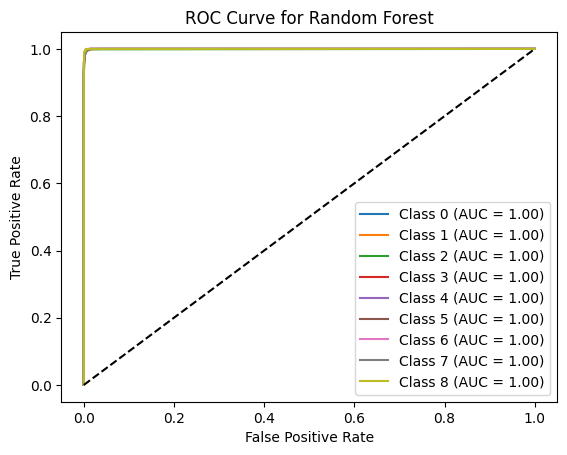

Regressão Logística:
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1373
           1       0.97      0.97      0.97      1799
           2       0.99      0.94      0.96       876
           3       0.93      1.00      0.96      3193
           4       1.00      0.95      0.97       685
           5       0.99      0.96      0.97      1284
           6       0.99      0.94      0.97       820
           7       0.98      0.95      0.96      1045
           8       1.00      0.92      0.96       455

    accuracy                           0.97     11530
   macro avg       0.98      0.96      0.97     11530
weighted avg       0.97      0.97      0.97     11530

AUC-ROC (Regressão Logística): 1.00


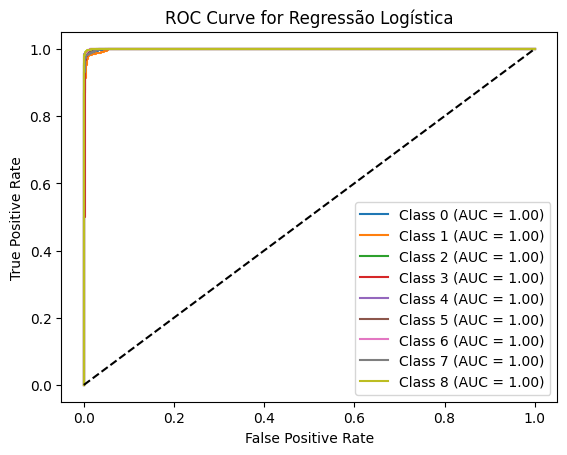

SVM:
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1373
           1       0.95      0.97      0.96      1799
           2       0.99      0.95      0.97       876
           3       0.95      1.00      0.98      3193
           4       1.00      0.96      0.98       685
           5       0.98      0.96      0.97      1284
           6       0.99      0.95      0.97       820
           7       0.98      0.95      0.97      1045
           8       1.00      0.96      0.98       455

    accuracy                           0.97     11530
   macro avg       0.98      0.96      0.97     11530
weighted avg       0.97      0.97      0.97     11530

AUC-ROC (SVM): 1.00


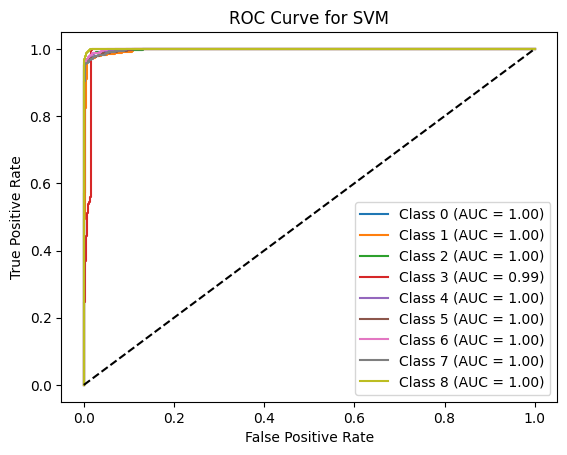

In [8]:
# Random Forest
print("Random Forest:")
evaluate_model(best_random_forest, features_test, labels_test)
plot_roc_curve(best_random_forest, features_test, labels_test, model_name="Random Forest")

# Regressão Logística
print("Regressão Logística:")
evaluate_model(logistic_regression, features_test, labels_test)
plot_roc_curve(logistic_regression, features_test, labels_test, model_name="Regressão Logística")

# SVM
print("SVM:")
evaluate_model(svm, features_test, labels_test)
plot_roc_curve(svm, features_test, labels_test, model_name="SVM")

## 5. Visualização com t-SNE: Aplicar a técnica de t-SNE nos dados textuais vetorizados para reduzir a dimensionalidade e visualizar os agrupamentos de documentos de maneira intuitiva, facilitando a identificação de padrões e outliers.

In [9]:
from sklearn.manifold import TSNE

features_np=features.to_numpy()

# usar 10% para agilizar a computacao
subsample_size = int(len(features_np) * 0.1)
indices = np.random.choice(len(features_np), subsample_size, replace=False)
features_sample = features_np[indices]

# aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=50, max_iter=250)
features_2d = tsne.fit_transform(features_sample)

print("t-SNE finalizado:", features_2d.shape)

t-SNE finalizado: (5764, 2)


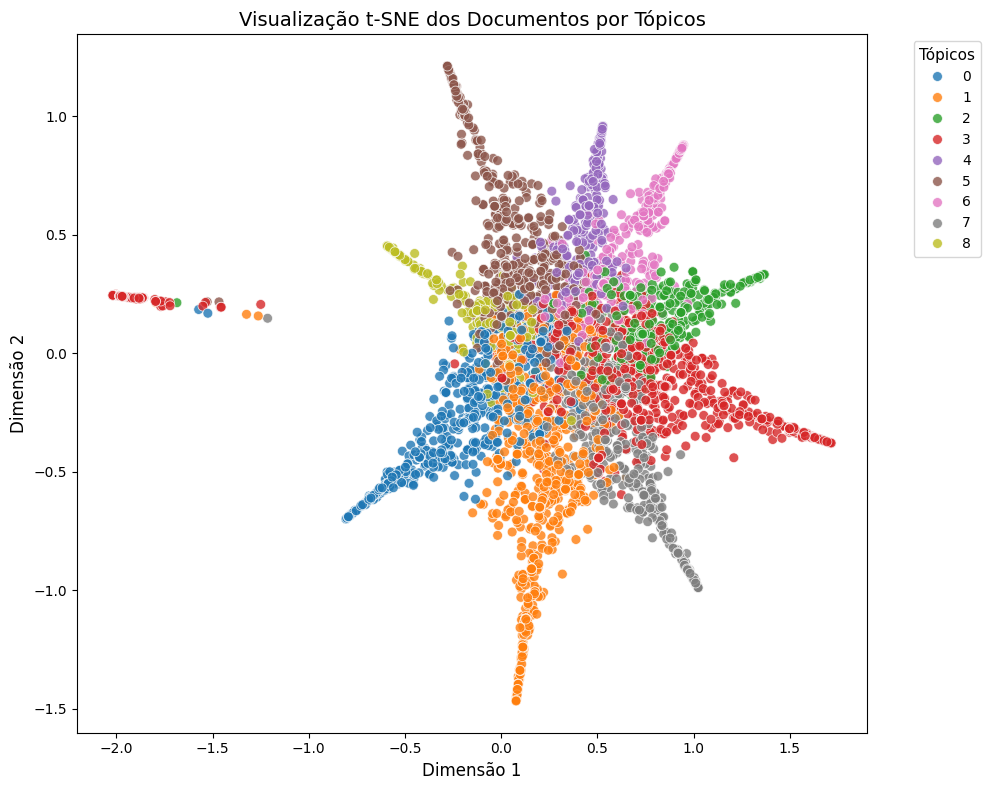

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

labels_subsample = labels.iloc[indices]

tsne_df = pd.DataFrame({
    'x': features_2d[:, 0],
    'y': features_2d[:, 1],
    'Rótulo do Tópico': labels_subsample.values
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x', y='y', hue='Rótulo do Tópico', palette='tab10', data=tsne_df, s=50, alpha=0.8
)
plt.title("Visualização t-SNE dos Documentos por Tópicos", fontsize=14)
plt.xlabel("Dimensão 1", fontsize=12)
plt.ylabel("Dimensão 2", fontsize=12)
plt.legend(title="Tópicos", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

### 6. Interpretação de Modelos com LIME, SHAP e Force-Plot: Utilizar SHAP para explicar as previsões individuais, identificando a contribuição de cada feature para a decisão do modelo. O force-plot será usado para visualizar essas contribuições de maneira agregada, oferecendo insights sobre a lógica de decisão do modelo.

AssertionError: Feature and SHAP matrices must have the same number of rows!

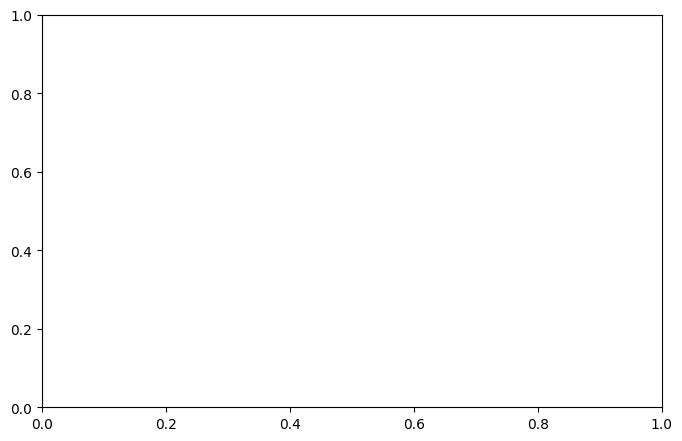

In [ ]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(best_random_forest)
shap_values = explainer.shap_values(features_test)

# Visualizar uma explicação individual
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],
    features_test.iloc[0]
)

# Visualizar explicações agregadas
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][:10],
    features_test.iloc[:10]
)

shap.summary_plot(shap_values[1], features_test)
shap.dependence_plot("Feature_1", shap_values[1], features_test)

### 7. Análise dos resultados: Enumere as conclusões que podem ser tomadas a partir dos resultados obtidos.

* O modelo apresenta alta performance com métricas acima de 99%, indicando robustez e boa separação de classes.

* O t-SNE mostrou clusters bem definidos, sugerindo tópicos distintos, embora pequenas sobreposições possam indicar similaridades entre eles.

* Classes menores podem estar sub-representadas, e métodos como t-SNE e SHAP são computacionalmente caros. Tive dificuldades em realizar em computar o t-SNE (precisei diminuir bastante o número de iterações) e não consegui realizar o SHAP.